# A topic modeling analysis of V. Putin’s addresses transcripts
Vasyukova Viktorija

In [0]:
#following lines are for google colab
#cells with LDA were launched there
!pip install html2text
!pip install pymorphy2
!pip install nltk
!pip install pyLDAvis

     |████████████████████████████████| 51kB 1.7MB/s 
     |████████████████████████████████| 7.1MB 6.9MB/s 
     |████████████████████████████████| 1.6MB 2.4MB/s 
     |████████████████████████████████| 552kB 15.9MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=0247c88cd52cb629ba45b6d0a1f120da24d67d4703e463275abff056b1463a35
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=3232c1afe28b65707159011df7658afb8917fdb4bc167c850aff6d8541554b55
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


In [1]:
import re
from urllib.request import Request, urlopen
import time
import csv
import html2text
import pymorphy2
import pandas as pd
import numpy as np
import scipy as sp
import sklearn
import sys
import string
from nltk.corpus import stopwords
import nltk
from gensim.models import ldamodel, TfidfModel, LdaMulticore, CoherenceModel
import gensim.corpora
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
sns.set_palette("RdBu")
sns.set_style("whitegrid")
import pyLDAvis
import pyLDAvis.gensim
import calendar

## Downloading the data

Dmitry Medvedev was President from the 7th of May 2008 till the 7th of May 2012. We omit the transcripts from that period. 

In [0]:
links = []
pattern = "(\"/events/president/transcripts/speeches/\d{5}\")"

for i in range(1,38):
    url = "http://kremlin.ru/events/president/transcripts/speeches/page/" + str(i)
    page = urlopen(url).read().decode("utf8")
    
    links.append(re.findall(pattern, page))

In [0]:
links_sorted = sorted(list(set([y for x in links for y in x])))
texts = {}
i=0
for link in links_sorted:
    url = "http://kremlin.ru/events/president/transcripts/copy/" + link[-6:-1]
    h = html2text.HTML2Text()
    try:
        req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
        page = urlopen(req).read().decode("utf8")
        texts[url] = h.handle(page)
        i+=1
        print("Success wiht link №" + str(i))
        if i%15==0:
            time.sleep(45)
    except:
        print("Error")
        continue

Success wiht link №1
Success wiht link №2
Success wiht link №3
Success wiht link №4
Success wiht link №5
Success wiht link №6
Success wiht link №7
Success wiht link №8
Success wiht link №9
Success wiht link №10
Success wiht link №11
Success wiht link №12
Success wiht link №13
Success wiht link №14
Success wiht link №15
Success wiht link №16
Success wiht link №17
Success wiht link №18
Success wiht link №19
Success wiht link №20
Success wiht link №21
Success wiht link №22
Success wiht link №23
Success wiht link №24
Success wiht link №25
Success wiht link №26
Success wiht link №27
Success wiht link №28
Success wiht link №29
Success wiht link №30
Success wiht link №31
Success wiht link №32
Success wiht link №33
Success wiht link №34
Success wiht link №35
Success wiht link №36
Success wiht link №37
Success wiht link №38
Success wiht link №39
Success wiht link №40
Success wiht link №41
Success wiht link №42
Success wiht link №43
Success wiht link №44
Success wiht link №45
Success wiht link №

Success wiht link №364
Success wiht link №365
Success wiht link №366
Success wiht link №367
Success wiht link №368
Success wiht link №369
Success wiht link №370
Success wiht link №371
Success wiht link №372
Success wiht link №373
Success wiht link №374
Success wiht link №375
Success wiht link №376
Success wiht link №377
Success wiht link №378
Success wiht link №379
Success wiht link №380
Success wiht link №381
Success wiht link №382
Success wiht link №383
Success wiht link №384
Success wiht link №385
Success wiht link №386
Success wiht link №387
Success wiht link №388
Success wiht link №389
Success wiht link №390
Success wiht link №391
Success wiht link №392
Success wiht link №393
Success wiht link №394
Success wiht link №395
Success wiht link №396
Success wiht link №397
Success wiht link №398
Success wiht link №399
Success wiht link №400
Success wiht link №401
Success wiht link №402
Success wiht link №403
Success wiht link №404
Success wiht link №405
Success wiht link №406
Success wih

Success wiht link №721
Success wiht link №722
Success wiht link №723
Success wiht link №724
Success wiht link №725
Success wiht link №726
Success wiht link №727
Success wiht link №728
Success wiht link №729
Success wiht link №730
Success wiht link №731
Success wiht link №732
Success wiht link №733
Success wiht link №734
Success wiht link №735
Success wiht link №736
Success wiht link №737
Success wiht link №738
Success wiht link №739
Success wiht link №740


We have 740 texts

In [0]:
len(texts)

740

Saving as csv for safety reasons since download takes a lot of time:

In [0]:
f = open("texts.csv", "w")
writer = csv.writer(f)
writer.writerow(["link","text"])
for key, value in texts.items():
    writer.writerow([key, value])
f.close()

## Preparing the data 

In [42]:
data = pd.read_csv('texts.csv')
data_text = data[['text']]
#empty columns for future 
data_text["date"] = np.nan
data_text["tokens"] = np.nan
data_text["lemmas"] = np.nan
data_text = data_text.astype('str')

In [0]:
data_text.loc[1,'text']

'Выступление на приёме в честь Дня России 2012-06-12 15:00:00 Москва, Кремль\nВ.Путин: Дамы и господа! Коллеги! Друзья! Поздравляю вас с Днём России. Этот\nобщенациональный праздник знаменует не только кардинальные демократические и\nэкономические преобразования, которые начались более двадцати лет назад, но и\nвесь исторический путь Российского государства, которое непрерывно развивается\nи живёт уже более одиннадцати веков. Для нас и для будущих поколений крайне\nважно осознавать этот великий созидательный масштаб. Уметь ценить прошлое и\nего глубинный смысл. Сохранять преемственность национальных, духовных\nтрадиций, понимать их значимость для решения задач сегодняшнего дня и никогда\nне забывать, что Россия дала миру несравненные образцы истинного\nподвижничества, мужества, силы духа на ратном, трудовом и гражданском поприще.\nЧто в нашей стране были созданы подлинные культурные и литературные шедевры,\nуникальные научные открытия, что российский народ внёс огромный вклад в\nпрогре

Removing stop words, punctuation, numbers and dates (which go to a separate column):

In [0]:
stop_words = stopwords.words('russian')
stop_words.extend(['здравствуйте','уважаемая','уважаемый','уважаемые','товарищи','дамы', 'господа', 'коллеги', 'друзья','всё','что', 'это', 'так', 'вот', 'быть', 'как', 'в', '—', '–', 'к', 'на', '...','«'])


In [0]:
pattern = "(\d{4}-\d{2}-\d{2})"
for idx in range(len(data_text)):
    text = data_text.iloc[idx]['text']
    text = text.lower()
    date = re.search(pattern,text).group(0)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    data_text.iloc[idx]['tokens'] = [word for word in text.split(' ') if word not in stop_words and word != ""]
    data_text.iloc[idx]['date'] = date

<>:1: DeprecationWarning: invalid escape sequence \d
<>:6: DeprecationWarning: invalid escape sequence \[
<>:9: DeprecationWarning: invalid escape sequence \w
<>:1: DeprecationWarning: invalid escape sequence \d
<>:6: DeprecationWarning: invalid escape sequence \[
<>:9: DeprecationWarning: invalid escape sequence \w
<>:1: DeprecationWarning: invalid escape sequence \d
<>:6: DeprecationWarning: invalid escape sequence \[
<>:9: DeprecationWarning: invalid escape sequence \w
<ipython-input-145-28ced0b21d09>:1: DeprecationWarning: invalid escape sequence \d
  pattern = "(\d{4}-\d{2}-\d{2})"
<ipython-input-145-28ced0b21d09>:6: DeprecationWarning: invalid escape sequence \[
  text = re.sub('\[.*?\]', '', text)
<ipython-input-145-28ced0b21d09>:9: DeprecationWarning: invalid escape sequence \w
  text = re.sub('\w*\d\w*', '', text)


Separating the speeches from titles and lemmatizing them if their POS tags interest us (we're leaving nouns, verbs, both forms of adjectives with comparatives, participles and gerunds).

In [0]:
morph = pymorphy2.MorphAnalyzer()
for idx in range(len(data_text)):
    text = data_text.iloc[idx]['tokens']
    for i in reversed(range(len(text))):
        if text[i]=="впутин":
            text = text[i+1:]
            break
    data_text.iloc[idx]['tokens'] = text
    
    lemmas = []
    for token in text:
        p = morph.parse(token)[0]
        lemma = p.normal_form
        if p.tag.POS in ['VERB','NOUN','COMP','INFN','ADJF','ADJS','PRTF','PRTS','GRND']:
            if len(lemma)>3:
                lemmas.append(lemma)
    data_text.iloc[idx]['lemmas'] = lemmas

In [0]:
data_text.head(10)

,text,date,tokens,lemmas
0,Стенографический отчёт о церемонии вручения Го...,2012-06-12,"[дорогие, ещё, искренне, поздравляю, присужден...","[дорогой, поздравлять, присуждение, государств..."
1,Выступление на приёме в честь Дня России 2012-...,2012-06-12,"[поздравляю, днём, россии, общенациональный, п...","[поздравлять, россия, общенациональный, праздн..."
2,Награждение 393-й авиационной базы ВВС России ...,2012-06-14,"[лётчики, офицеры, сержанты, солдаты, ветераны...","[лётчик, офицер, сержант, солдат, ветеран, поз..."
3,Выступление на открытии причального комплекса ...,2012-06-15,"[хочу, обратиться, руководству, компании, «рос...","[хотеть, обратиться, руководство, компания, ве..."
4,Петербургский международный экономический фору...,2012-06-21,"[добрый, день, дорогие, участники, нашей, встр...","[добрый, день, дорогой, участник, встреча, при..."
5,Открытие Мемориала победы Красной армии над фа...,2012-06-25,"[увидел, услышал, производит, очень, сильное, ...","[увидеть, услышать, производить, сильный, эмоц..."
6,Торжественный приём от имени Президента Израил...,2012-06-25,"[господин, президент, речь, просто, несколько,...","[господин, президент, речь, слово, связь, сего..."
7,Выступления на открытии Российского центра нау...,2012-06-26,"[господин, президент, аббас, дорогие, сегодня,...","[господин, президент, аббас, дорогой, вифлеем,..."
8,Заседание Совета Федерации 2012-06-27 14:30:00...,2012-06-27,"[валентина, ивановна, хочу, прежде, поблагодар...","[валентин, иван, хотеть, поблагодарить, констр..."
9,Приём в честь выпускников военных академий и у...,2012-06-28,"[офицеры, рад, приветствовать, поздравить, усп...","[офицер, приветствовать, поздравить, успешный,..."


In [0]:
pickle.dump(data_text, open('data_text.dat', 'wb'))

## LDA

In [0]:
data = pd.read_pickle('data_text.dat')

In [0]:
id2word = gensim.corpora.Dictionary(data["lemmas"])
corpus = [id2word.doc2bow(text) for text in data["lemmas"]]
tfidf = TfidfModel(corpus)
t = tfidf[corpus]

We can use tf-idf matrix as an input in LDA model because this way we can get rid of too rare or frequent words like (greetings, Russia and its derivatives and etc.). However, when launching the following cells we get really bad models.

Here we can play with parameters to get a better understanding of what they should be to make the output more meaningful.

In [0]:
num_topics = 12
lda = ldamodel.LdaModel(t, id2word=id2word, num_topics=num_topics,
                        minimum_probability=0.8,
                        random_state = 100,
                        update_every=1,
                        passes=20,
                        alpha='auto',
                        per_word_topics=True)

In [0]:
word_dict = {}
for i in range(num_topics):
    words = lda.show_topic(i, topn = 10)
    word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dict)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,Topic # 11,Topic # 12
0,свидание,моряк,палестинский,асеана,географический,азербайджан,служба,человек,нельсон,война,хоккейный,максим
1,радда,военноморский,нурсултан,туберкулёз,чуткий,воздушнодесантный,работа,народ,профсоюз,подвиг,лига,евгений
2,маргарита,ашохин,абиш,мгимо,щедрость,ринг,задача,праздник,южноафриканский,победа,москвич,примаков
3,сингапур,корабль,необычный,мордовский,фотография,император,безопасность,господин,устроитель,нацизм,ночной,атлетика
4,покрышкин,поисковик,аргентинский,океанариум,волнение,черноморский,военный,лауреат,трёхсторонний,герой,любительский,манёвр
5,исай,береговой,рублёв,пограничник,многодетный,пристав,государство,русский,мандела,украина,турку,объявлять
6,студенчество,аргентина,стройка,суворовский,дима,нечерноземье,организация,спорт,нягань,память,объявлять,примак
7,«эксон,флотский,аргентина,расул,семейный,деться,флот,отношение,сопоставимый,враг,сезон,эльвира
8,ступенька,карьера,мостовый,тульский,«родительский,результативность,система,друг,песнь,солдат,останавливаться,мост
9,лестница,надводный,поместиться,вступительный,хату,дрезденский,сила,замечательный,струя,женщина,евразэс,поехать


To determine optimal number of topics we calculate topic coherence for topic models and draw a plot. Code taken from https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/ 

In [0]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = lda = ldamodel.LdaModel(corpus, id2word=id2word, num_topics=num_topics,
                        minimum_probability=0,
                        update_every=2,
                        passes=20,
                        alpha='auto',
                        random_state=100,
                        per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [0]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data["lemmas"], start=2, limit=30, step=2)

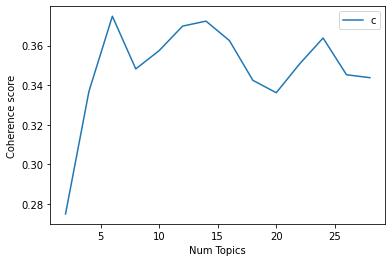

In [0]:
limit=30; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.savefig("c_v_graph.png",dpi=300)
plt.show()

According to the graph above we can assume that num_topics should be around 6.

In [0]:
lda = model_list[2]
word_dict = {}
for i in range(6):
    words = lda.show_topic(i, topn = 10)
    word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dict)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06
0,который,россия,россия,россия,который,который
1,работа,отношение,страна,свой,россия,страна
2,должный,страна,развитие,страна,человек,работа
3,человек,сотрудничество,который,который,страна,развитие
4,страна,народ,российский,сила,свой,самый
5,россия,международный,работа,народ,хотеть,хотеть
6,гражданин,который,сотрудничество,великий,весь,человек
7,важный,российский,проект,война,самый,такой
8,свой,президент,экономика,дорогой,спорт,весь
9,решение,республика,хотеть,самый,большой,должный


*Here I forgot to save the model so I created a bit different new one with the same parameters.*

Visualization via pyLDAvis lets us see how far from each other they are.

In [0]:
lda = ldamodel.LdaModel(corpus, id2word=id2word, num_topics=6,
                        minimum_probability=0,
                        update_every=2,
                        passes=20,
                        alpha='auto',
                        random_state=11,
                        per_word_topics=True)
lda.save('lda.model')
lda =  ldamodel.LdaModel.load('lda.model')

In [0]:
word_dict = {}
for i in range(6):
    words = lda.show_topic(i, topn = 10)
    word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dict)

In [0]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda,corpus,id2word)
pyLDAvis.save_html(vis,'vis.html')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.105073  0.052106       1        1  23.403244
5     -0.016088  0.042649       2        1  20.125216
3     -0.148459 -0.012244       3        1  17.479139
2      0.137490  0.094267       4        1  16.473061
1     -0.028910 -0.104505       5        1  14.107509
0      0.161039 -0.072272       6        1   8.411832, topic_info=                Term         Freq        Total Category  logprob  loglift
1330  сотрудничество   608.000000   608.000000  Default  30.0000  30.0000
18           дорогой   604.000000   604.000000  Default  29.0000  29.0000
73          праздник   403.000000   403.000000  Default  28.0000  28.0000
54             народ   678.000000   678.000000  Default  27.0000  27.0000
128          человек  1294.000000  1294.000000  Default  26.0000  26.0000
...              ...          ...          ...      ...      ...      ...
42           который   123.052467  2200.999023   Topic6  -5.0111  -0.4085
96             самый    98.569809  1039.044922   Topic6  -5.2329   0.1202
35           история    82.033829   396.081970   Topic6  -5.4166   0.9010
139             весь    89.221054  1016.439819   Topic6  -5.3326   0.0426
61              один    77.320969   802.026794   Topic6  -5.4757   0.1364

[541 rows x 6 columns], token_table=       Topic      Freq             Term
term                                   
9249       2  0.973473          «единый
9249       5  0.017383          «единый
4552       4  0.904650    «родительский
6544       1  0.950243          австрия
11320      3  0.919314  азербайджанский
...      ...       ...              ...
3270       1  0.140783            яркий
3270       2  0.084470            яркий
3270       4  0.694531            яркий
3270       5  0.018771            яркий
3270       6  0.056313            яркий

[1368 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 6, 4, 3, 2, 1])

In [0]:
all_topics = lda.get_document_topics(corpus, minimum_probability =0,per_word_topics=False)
topic = []
for t in all_topics:
  maximum = 0
  for tpl in t:
    if tpl[1]>maximum:
      maximum = tpl[1]
      top = tpl[0]+1
  topic.append(top)
data["topic"] = topic

In [0]:
data["date"] = pd.to_datetime(data["date"])

In [0]:
month = []
year = []
for d in data["date"]:
  month.append(calendar.month_name[d.month])
  year.append(d.year)
data["month"] = month
data["year"] = year

In [0]:
pickle.dump(data, open('data.dat', 'wb'))

In [2]:
data = pd.read_pickle('data.dat')
data.head(5)

,text,date,tokens,lemmas,topic,month,year
0,Стенографический отчёт о церемонии вручения Го...,2012-06-12,"[дорогие, ещё, искренне, поздравляю, присужден...","[дорогой, поздравлять, присуждение, государств...",3,June,2012
1,Выступление на приёме в честь Дня России 2012-...,2012-06-12,"[поздравляю, днём, россии, общенациональный, п...","[поздравлять, россия, общенациональный, праздн...",6,June,2012
2,Награждение 393-й авиационной базы ВВС России ...,2012-06-14,"[лётчики, офицеры, сержанты, солдаты, ветераны...","[лётчик, офицер, сержант, солдат, ветеран, поз...",1,June,2012
3,Выступление на открытии причального комплекса ...,2012-06-15,"[хочу, обратиться, руководству, компании, «рос...","[хотеть, обратиться, руководство, компания, ве...",4,June,2012
4,Петербургский международный экономический фору...,2012-06-21,"[добрый, день, дорогие, участники, нашей, встр...","[добрый, день, дорогой, участник, встреча, при...",4,June,2012


In [85]:
bytopic = data.groupby(["topic"]).count()["text"].to_list()
byyear = data.groupby(["year"]).count()["text"].to_list()
byyeartopic = data.groupby(["year","topic"]).count()["text"].to_list()
bytopic, byyear, byyeartopic

([67, 78, 230, 106, 145, 114],
 [42, 92, 85, 76, 97, 100, 125, 103, 20],
 [7,
  6,
  8,
  7,
  6,
  8,
  8,
  11,
  31,
  12,
  18,
  12,
  8,
  7,
  33,
  12,
  16,
  9,
  5,
  9,
  26,
  9,
  13,
  14,
  7,
  9,
  27,
  16,
  20,
  18,
  8,
  13,
  30,
  15,
  18,
  16,
  11,
  8,
  35,
  17,
  30,
  24,
  8,
  13,
  35,
  16,
  22,
  9,
  5,
  2,
  5,
  2,
  2,
  4])

In [87]:
byyear6 = []
for i in byyear:
  byyear6.append([i]*6)
bytopic6

from itertools import chain
byyear6 = list(chain(*byyear6))
byyear6

[42,
 42,
 42,
 42,
 42,
 42,
 92,
 92,
 92,
 92,
 92,
 92,
 85,
 85,
 85,
 85,
 85,
 85,
 76,
 76,
 76,
 76,
 76,
 76,
 97,
 97,
 97,
 97,
 97,
 97,
 100,
 100,
 100,
 100,
 100,
 100,
 125,
 125,
 125,
 125,
 125,
 125,
 103,
 103,
 103,
 103,
 103,
 103,
 20,
 20,
 20,
 20,
 20,
 20]

In [104]:
a=np.array(bytopic, dtype=np.float)
rate = a/740.0
rate*100

array([ 9.05405405, 10.54054054, 31.08108108, 14.32432432, 19.59459459,
       15.40540541])

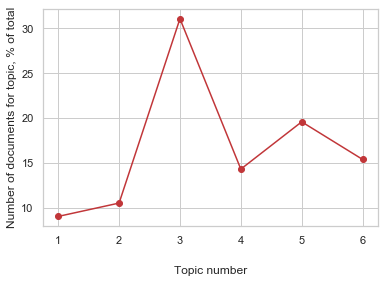

In [113]:
plt.figure()
plt.plot([1,2,3,4,5,6],rate*100,marker="o")
plt.xlabel('Topic number', labelpad=20)
plt.ylabel('Number of documents for topic, % of total')
plt.savefig('rate.png', dpi=300, bbox_inches="tight")

In [100]:
a=np.array(byyeartopic, dtype=np.float)
b=np.array(byyear6, dtype=np.float)
rate = a/b
rate = rate*100

In [93]:
topic_year_p = pd.DataFrame([rate[i:i + 6] for i in range(0, len(rate), 6)])
topic_year_p

,0,1,2,3,4,5
0,16.666667,14.285714,19.047619,16.666667,14.285714,19.047619
1,8.695652,11.956522,33.695652,13.043478,19.565217,13.043478
2,9.411765,8.235294,38.823529,14.117647,18.823529,10.588235
3,6.578947,11.842105,34.210526,11.842105,17.105263,18.421053
4,7.216495,9.278351,27.835052,16.494845,20.618557,18.556701
5,8.000000,13.000000,30.000000,15.000000,18.000000,16.000000
6,8.800000,6.400000,28.000000,13.600000,24.000000,19.200000
7,7.766990,12.621359,33.980583,15.533981,21.359223,8.737864
8,25.000000,10.000000,25.000000,10.000000,10.000000,20.000000


In [94]:
topic_year_p.index = [2012,2013,2014,2015,2016,2017,2018,2019,2020]
topic_year_p.index

Int64Index([2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], dtype='int64')

In [95]:
topic_year_p.columns = [1,2,3,4,5,6]
topic_year_p.columns

Int64Index([1, 2, 3, 4, 5, 6], dtype='int64')

In [98]:
topic_year_p.iloc[4,:].sum()

100.0

<Figure size 432x288 with 0 Axes>

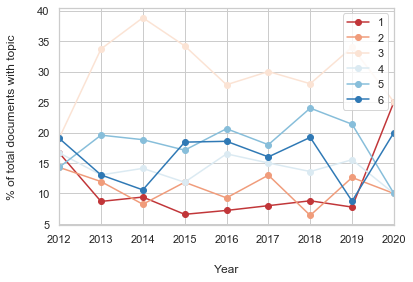

In [114]:
plt.figure()
topic_year_p.iloc[:,:].plot(marker="o")
plt.xlabel('Year', labelpad=20)
plt.ylabel('% of total documents with topic', labelpad=20)
plt.legend(loc=1)
plt.savefig('topic-year-1.png', dpi=300, bbox_inches="tight")

In [23]:
data.groupby(["month"]).count()["text"]

month
April         44
August        43
December     101
February      45
January       13
July          62
June          95
March         59
May           67
November      77
October       63
September     71
Name: text, dtype: int64

In [17]:
bymonth = data.groupby(["month"]).count()["text"].to_list()
bymonthtopic = data.groupby(["month","topic"]).count()["text"].to_list()
bymonth, bymonthtopic

([44, 43, 101, 45, 13, 62, 95, 59, 67, 77, 63, 71],
 [2,
  5,
  10,
  10,
  10,
  7,
  4,
  4,
  15,
  7,
  6,
  7,
  10,
  22,
  30,
  14,
  7,
  18,
  11,
  3,
  14,
  4,
  8,
  5,
  1,
  1,
  5,
  1,
  2,
  3,
  13,
  9,
  11,
  6,
  16,
  7,
  3,
  12,
  33,
  16,
  21,
  10,
  6,
  6,
  21,
  4,
  6,
  16,
  5,
  36,
  6,
  13,
  7,
  5,
  6,
  26,
  10,
  19,
  11,
  2,
  7,
  15,
  12,
  18,
  9,
  5,
  3,
  14,
  16,
  19,
  14])

In [18]:
bymonthtopic.insert(-22,0)
bymonthtopic

[2,
 5,
 10,
 10,
 10,
 7,
 4,
 4,
 15,
 7,
 6,
 7,
 10,
 22,
 30,
 14,
 7,
 18,
 11,
 3,
 14,
 4,
 8,
 5,
 1,
 1,
 5,
 1,
 2,
 3,
 13,
 9,
 11,
 6,
 16,
 7,
 3,
 12,
 33,
 16,
 21,
 10,
 6,
 6,
 21,
 4,
 6,
 16,
 5,
 0,
 36,
 6,
 13,
 7,
 5,
 6,
 26,
 10,
 19,
 11,
 2,
 7,
 15,
 12,
 18,
 9,
 5,
 3,
 14,
 16,
 19,
 14]

In [19]:
bymonth6 = []
for i in bymonth:
  bymonth6.append([i]*6)
bymonth6

from itertools import chain
bymonth6 = list(chain(*bymonth6))
len(bymonth6)

72

In [20]:
a=np.array(bymonthtopic, dtype=np.float)
b=np.array(bymonth6, dtype=np.float)
rate = a/b
rate = rate*100

In [21]:
topic_month_p = pd.DataFrame([rate[i:i + 6] for i in range(0, len(rate), 6)])
topic_month_p

,0,1,2,3,4,5
0,4.545455,11.363636,22.727273,22.727273,22.727273,15.909091
1,9.302326,9.302326,34.883721,16.279070,13.953488,16.279070
2,9.900990,21.782178,29.702970,13.861386,6.930693,17.821782
3,24.444444,6.666667,31.111111,8.888889,17.777778,11.111111
4,7.692308,7.692308,38.461538,7.692308,15.384615,23.076923
5,20.967742,14.516129,17.741935,9.677419,25.806452,11.290323
6,3.157895,12.631579,34.736842,16.842105,22.105263,10.526316
7,10.169492,10.169492,35.593220,6.779661,10.169492,27.118644
8,7.462687,0.000000,53.731343,8.955224,19.402985,10.447761
9,6.493506,7.792208,33.766234,12.987013,24.675325,14.285714


In [25]:
topic_month_p.index = ["April","August","December","February","January","July","June","March","May","November","October","September"]
topic_month_p.index

Index(['April', 'August', 'December', 'February', 'January', 'July', 'June',
       'March', 'May', 'November', 'October', 'September'],
      dtype='object')

In [26]:
topic_month_p.columns = [1,2,3,4,5,6]
topic_month_p.columns

Int64Index([1, 2, 3, 4, 5, 6], dtype='int64')

In [27]:
topic_month_p.iloc[4,:].sum()

100.00000000000001

In [36]:
cats = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
topic_month_p.index=pd.CategoricalIndex(topic_month_p.index, categories=cats, ordered=True)
topic_month_p = topic_month_p.sort_index()

In [37]:
topic_month_p

,1,2,3,4,5,6
January,7.692308,7.692308,38.461538,7.692308,15.384615,23.076923
February,24.444444,6.666667,31.111111,8.888889,17.777778,11.111111
March,10.169492,10.169492,35.593220,6.779661,10.169492,27.118644
April,4.545455,11.363636,22.727273,22.727273,22.727273,15.909091
May,7.462687,0.000000,53.731343,8.955224,19.402985,10.447761
June,3.157895,12.631579,34.736842,16.842105,22.105263,10.526316
July,20.967742,14.516129,17.741935,9.677419,25.806452,11.290323
August,9.302326,9.302326,34.883721,16.279070,13.953488,16.279070
September,7.042254,4.225352,19.718310,22.535211,26.760563,19.718310
October,3.174603,11.111111,23.809524,19.047619,28.571429,14.285714


<Figure size 432x288 with 0 Axes>

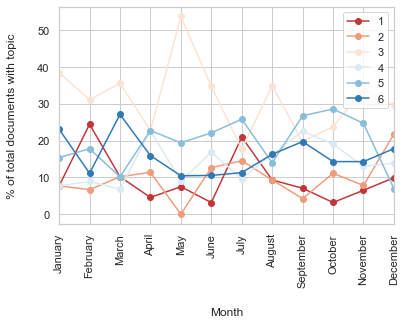

In [42]:
plt.figure()
topic_month_p.iloc[:,:].plot(marker="o")
plt.xticks(range(12), calendar.month_name[1:13],rotation=90)
plt.xlabel('Month', labelpad=20)
plt.ylabel('% of total documents with topic', labelpad=20)
plt.legend(loc=1)
plt.savefig('topic-month-1.png', dpi=300, bbox_inches="tight")

# NMF 

Here I tried to do NMF but than I realised I won't manage to finish it...

In [38]:
num_topics = 20 #make range

In [39]:
sentences = [' '.join(text) for text in data["lemmas"]]
vectorizer = CountVectorizer(analyzer='word', max_features=5000) #make range
x_counts = vectorizer.fit_transform(sentences)
transformer = TfidfTransformer(smooth_idf=False)
x_tfidf = transformer.fit_transform(x_counts)
xtfidf_norm = normalize(x_tfidf, norm='l1', axis=1)

#obtain a NMF model
model = NMF(n_components=num_topics, init='nndsvd', random_state=1)
#fit the model
model.fit(xtfidf_norm)

NMF(alpha=0.0, beta_loss='frobenius', init='nndsvd', l1_ratio=0.0, max_iter=200,
    n_components=20, random_state=None, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [40]:
def get_nmf_topics(model, n_top_words):
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = vectorizer.get_feature_names()
    word_dict = {};
    for i in range(num_topics):
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-20 - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words
    
    return pd.DataFrame(word_dict)

In [41]:
get_nmf_topics(model, 20)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,Topic # 11,Topic # 12,Topic # 13,Topic # 14,Topic # 15,Topic # 16,Topic # 17,Topic # 18,Topic # 19,Topic # 20
0,большой,удача,аплодисменты,крымчанин,праздник,давать,россия,приехать,ведущий,желать,модератор,добрый,завершать,объявлять,лауреат,частный,ребята,пожелание,участие,спорт
1,делать,поздравлять,смех,севастополец,поздравлять,начать,который,большой,большой,успех,сказать,начало,съезд,летний,дорогой,поездка,удача,передать,господин,футбол
2,господин,хороший,целый,крым,дорогой,производственный,страна,доброжелательный,давать,начало,хотеть,масштабный,работа,универсиада,наградить,хорошеть,хороший,самый,делать,игра
3,участие,весь,работать,севастополь,масштабный,сделать,человек,дискуссия,весь,масштабный,большой,производственный,весь,открытый,сказать,визит,боевой,хороший,прощаться,сборный
4,реакция,давать,сказать,украина,начало,весь,хотеть,смех,удача,поздравлять,дискуссия,сделать,наступить,атлетика,верить,добрый,братство,желать,работа,любить
5,поговорить,карьера,разговаривать,воссоединение,основательный,личный,свой,замечательный,дискуссия,работа,сделать,самый,начало,всемирный,сегодняшний,посвятить,дзюдо,коллектив,завтрашний,чемпионат
6,добрый,служебный,учиться,сделать,надежда,пожелать,быть,задать,живой,карьера,живой,карьера,большой,лёгкий,подавать,чувствоваться,гость,наступать,урок,хоккей
7,приближаться,поговорить,премьерминистр,россия,вселять,удача,российский,гость,интересный,строитель,интересный,работа,масштабный,чемпионат,будущее,шутка,учебный,доложить,школа,любитель
8,разный,приближаться,день,референдум,женщина,один,сделать,петербургский,благодарность,хотеть,удаться,личный,квартал,москва,человек,вкладывать,выиграть,закончиться,ждать,спортсмен
9,план,смех,команда,пронести,лауреат,самый,такой,фестиваль,удаться,служебный,благодарность,служебный,уйти,казань,замечательный,начинание,отличать,алексей,принимать,качество
